In [1]:
from qdhmc import HMC
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-07-13 20:55:02.666527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gromacs/lib
2023-07-13 20:55:02.666581: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-13 20:55:06.766283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/gromacs/lib
2023-07-13 20:55:06.766333: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-13 20:55:06.766366: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-HBHOF55J): /proc/driver/nvidia/ve

In [2]:
def guassian_log_prob(n, temp):
    def lp(x):
        return np.sum([-1 * x[i] for i in range(n)] + [-1 * x[i]**2 for i in range(n)])/temp
    return lp

def sphere_log_prob(n, temp):
    def lp(x):
        return -1 * np.sum([x[i]**2 for i in range(n)])/temp
    return lp

def double_well_log_prob(temp):
    def lp(x):
        return (-1*(x[0]**4 - 4 * x[0]**2 + x[1]**2) - 0.5 * x[0])/temp
    return lp

def rosenbrock(n, temp):
    def lp(x):
        return -1 * np.sum([10 * (x[i + 1] - x[i])**2 + (1 - x[i])**2 for i in range(n-1)])/temp
    return lp

def styblinski_tang(n, temp):
    def lp(x):
        return -1/2 * np.sum([x[i]**4 - 16 * x[i]**2 + 5 * x[i] for i in range(n)])/temp
    return lp

In [3]:
def run_exp(t, rep, precision, n, log_prob, experiments, step_size):
    classical = []
    quantum = []

    test_c = HMC(log_prob, kernel_type='classical', num_vars=n, precision=precision, step_size=step_size)
    test_q = HMC(log_prob, kernel_type='quantum', precision=precision, r=rep, num_vars=n, t=t)
    
    for e in range(experiments):
        init_state = tf.random.uniform(shape=[n], minval=-tf.math.sqrt(2 * np.pi * 2 ** precision) / 2, \
                                        maxval=tf.math.sqrt(2 * np.pi * 2 ** precision) / 2)
        
        init = log_prob(init_state)

        s, m, std, a, rs = test_c.run_hmc(1, 0, init_state=init_state)
        s_q, m_q, std_q, a_q, rs_q = test_q.run_hmc(1, 0, init_state=init_state)

        classical.append(a)
        quantum.append(a_q)
        
    return classical, quantum

In [6]:
step_size = 0.07948701832532529
trotter_time = 1.6141954191198948
trotter_steps = 3
precision = 5
n = 2
experiments = 100


In [7]:
temps = [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100.0]


c = []
q = []

for temp in temps:
    print(temp)
    log_prob = double_well_log_prob(temp)
    cc, qq = run_exp(trotter_time, trotter_steps, precision, n, log_prob, experiments, step_size)
    c.append(cc)
    q.append(qq)

1e-05
0.0001
0.001
0.01
0.05
0.1
0.5
1.0
10.0
100.0


In [12]:
def plot_exp(c, q, temps):
    cs_mean = np.mean(c, axis=1)
    qs_mean = np.mean(q, axis=1)

    cs_ci = 1.96 * np.std(c, axis=1)/np.sqrt(100)
    qs_ci = 1.96 * np.std(q, axis=1)/np.sqrt(100)

    fig, ax = plt.subplots(figsize=(5, 3))

    ax.plot(temps, cs_mean, label='Classical')
    ax.plot(temps, qs_mean, label='Quantum')

    ax.fill_between(temps, (cs_mean - cs_ci), (cs_mean + cs_ci), color='b', alpha=.1)
    ax.fill_between(temps, (qs_mean - qs_ci), (qs_mean + qs_ci), color='orange', alpha=.1)

    plt.xscale("log")
    plt.xlabel("Temperature")
    plt.ylabel("Acceptance Probability")
    plt.legend()
    plt.savefig("accept.svg", format = 'svg', dpi=300,bbox_inches='tight')
    plt.show()

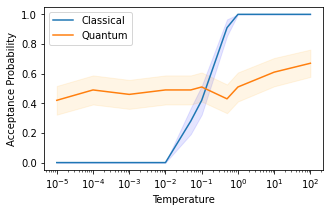

In [13]:
plot_exp(c, q, temps)